In [2]:
import qutip
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
plt.rcParams['text.usetex'] = True
import numpy as np

Bosonic case

In [489]:
U = 0.01
T = 50.0
x = np.linspace(-10, 10, 100)
N = 100

def compute_rho(U, t, alpha, N):
    psi = qutip.coherent(N,alpha).data.toarray()
    rho_0 = psi @ psi.conj().T
    inds = np.arange(N)
    rho_U = np.exp(-1.0j * U * t * (inds[:, np.newaxis]**2 - inds[np.newaxis, :]**2)) * rho_0
    rho_f = np.exp(-0.5 * t * (inds[:, np.newaxis] - inds[np.newaxis, :])**2) * rho_U
    return qutip.Qobj(rho_f)

-5.290884608056732e-05


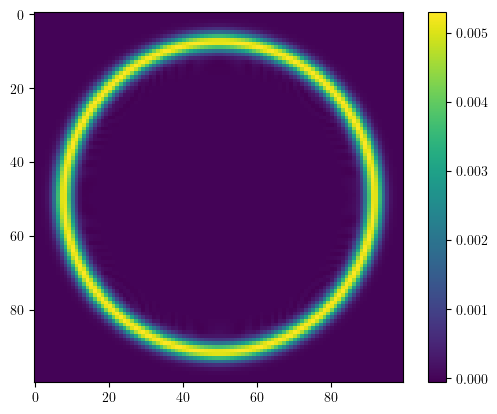

In [507]:
x = np.linspace(-20, 20, 100)
W = qutip.wigner(compute_rho(0.05, 10, 12, 500), x, x)
plt.imshow(W)
plt.colorbar()
print(np.min(W))

In [485]:
min_wig = []
max_wig = []
tlist = np.linspace(0, 50, 100)
alphas = [4.5, 5]
for alpha in alphas:
    print("On alpha = {}".format(alpha))
    t_wig = []
    min_wig_alpha = []
    max_wig_alpha = []
    for k, t in enumerate(tlist):
        W = qutip.wigner(compute_rho(U, t, alpha, N), x, x)
        min_wig_alpha.append(np.min(W))
        max_wig_alpha.append(np.max(W))
        t_wig.append(t)

    min_wig.append(min_wig_alpha)
    max_wig.append(max_wig_alpha)

On alpha = 4.5
On alpha = 5


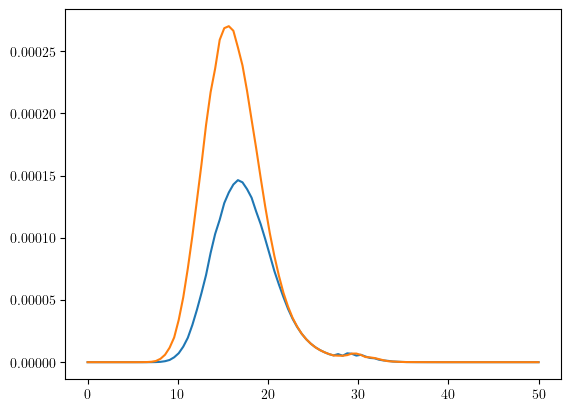

In [488]:
for j, alpha in enumerate(alphas):
    plt.plot(t_wig, -np.array(min_wig[j]) / np.array(max_wig[j]))

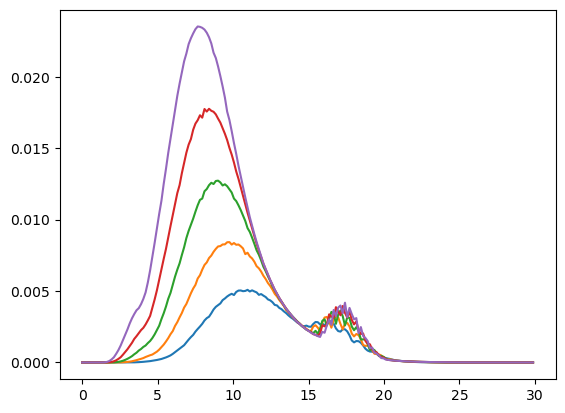

In [26]:
np.save("data_U_{}_alphas".format(U), alphas)
np.save("data_U_{}_min_wg".format(U), min_wig)
np.save("data_U_{}_max_wg".format(U), max_wig)
np.save("data_U_{}_times".format(U), t_wig)


for j, alpha in enumerate(alphas):
    plt.plot(t_wig, -np.array(min_wig[j]) / np.array(max_wig[j]))


<Figure size 600x500 with 0 Axes>

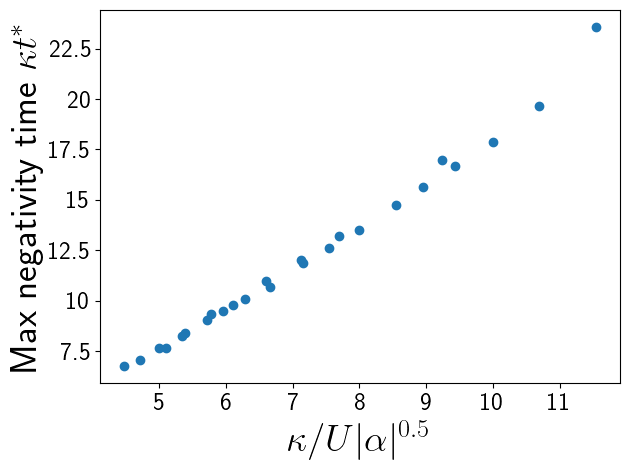

In [399]:
plt.figure(figsize=(6, 5))
alphas = np.load("data_U_0.1_alphas.npy")
Us = [0.05, 0.0625, 0.075, 0.0875, 0.1]
times = []
rates = []
for U in Us:
    t_wg = np.load("data_U_{}_times.npy".format(U))
    min_wg = np.load("data_U_{}_min_wg.npy".format(U))
    max_wg = np.load("data_U_{}_max_wg.npy".format(U))
    for k, alpha in enumerate(alphas):
        ind = np.argmax(-min_wg[k] / max_wg[k])
        times.append(t_wg[ind])
        rates.append((1.0 / (U * alpha**0.5)))

fig, ax = plt.subplots()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
# ax.axis([0.08, 0.24, 6, 25])
#ax.loglog()
for axis in [ax.xaxis, ax.yaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)
# ax.set_xticks([0.1, 0.15, 0.2])
# ax.set_yticks([6, 10, 20])
ax.plot(np.array(rates), times, 'o')

ax.set_xlabel(r"$\kappa/U |\alpha|^{0.5}$", fontsize=27)
ax.set_ylabel("Max negativity time $\kappa t^*$", fontsize=27)
plt.tight_layout()
plt.savefig("bosonic_negativity_time.pdf")

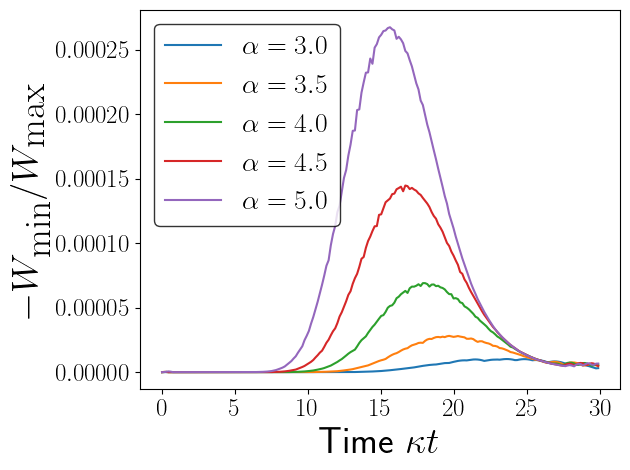

In [378]:
fig, ax = plt.subplots()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
alphas = np.load("data_U_0.1_alphas.npy")
U = 0.05
times = []
rates = []
for k, alpha in enumerate(alphas):
    t_wg = np.load("data_U_{}_times.npy".format(U))
    min_wg = np.load("data_U_{}_min_wg.npy".format(U))
    max_wg = np.load("data_U_{}_max_wg.npy".format(U))
    ax.plot(t_wg, -min_wg[k] / max_wg[k], label=r"$\alpha = {}$".format(alpha))


ax.set_xlabel(r"Time $\kappa t$", fontsize=27)
ax.set_ylabel(r"$- W_\textnormal{min} /  W_\textnormal{max}$", fontsize=27)
plt.legend(edgecolor="k", fontsize=20)
plt.tight_layout()
plt.savefig("bosonic_negativity_U_{}.pdf".format(U))

## Fermionic case: All observables 

In [372]:
a1 = qutip.tensor(qutip.qeye(2), qutip.destroy(2))
a2 = qutip.tensor(qutip.destroy(2), qutip.sigmaz())
H = a1.dag() * a2 + a2.dag() * a1

vac = qutip.tensor(qutip.fock(2, 0), qutip.fock(2, 0))
psi_0 = a1.dag() * vac

tlist = np.linspace(0, 5, 2000)


In [373]:
od_mask = (np.ones((4, 4), dtype=complex) -
           np.eye(4, dtype=complex))
print(od_mask)
od_mag = []

kappas = np.arange(1, 21)
for kappa in kappas:
    od_mag_kappa = []
    res = qutip.mesolve(H,psi_0,tlist,[np.sqrt(kappa) * a1, np.sqrt(kappa) * a2,
                                       np.sqrt(kappa) * a1.dag(), np.sqrt(kappa) * a2.dag()]) 
    for k, _ in enumerate(tlist):
        od_mag_kappa.append(np.sum(np.abs(od_mask * res.states[k].data.toarray())))
    od_mag.append(od_mag_kappa)

[[0.+0.j 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j 0.+0.j]]


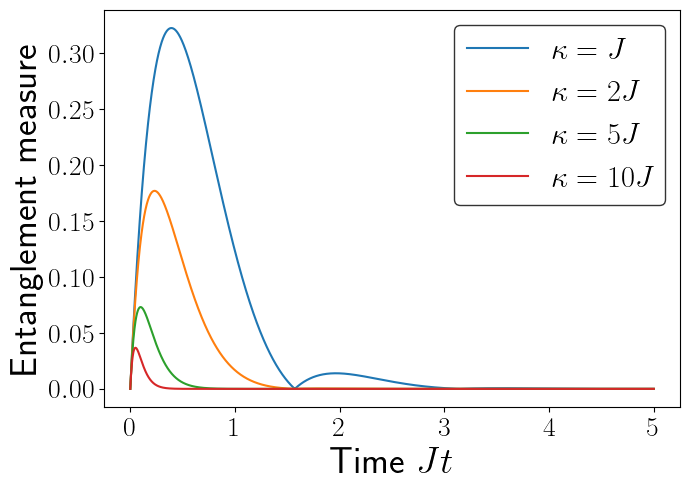

In [374]:
plt.figure(figsize=(7, 5))
t_min = []
for k, kappa in enumerate(kappas):
    ind = np.argmax(od_mag[k])
    t_min.append(tlist[ind])
    if kappa == 1:
        plt.plot(tlist, (od_mag[k]), label="$\kappa = J$".format(kappa))
    if kappa in [2, 5, 10]:
        plt.plot(tlist, (od_mag[k]), label="$\kappa = {}J$".format(kappa))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time $Jt$", fontsize=27)
plt.ylabel("Entanglement measure", fontsize=27)
plt.legend(edgecolor="k",fontsize=22)
plt.tight_layout()
plt.savefig("entanglement_all_obs_ferm.pdf")

In [379]:
a1 = qutip.tensor(qutip.qeye(2), qutip.destroy(2))
a2 = qutip.tensor(qutip.destroy(2), qutip.sigmaz())
H = a1.dag() * a2 + a2.dag() * a1

vac = qutip.tensor(qutip.fock(2, 0), qutip.fock(2, 0))
psi_0 = a1.dag() * vac

tlist = np.linspace(0, 5, 2000)

In [380]:
a1 * a2 + a2 * a1

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [388]:
od_mask = (np.ones((4, 4), dtype=complex) -
           np.eye(4, dtype=complex))
print(od_mask)
od_mag = []

Js = np.linspace(0.1, 1, 20)
for J in Js:
    od_mag_J= []
    res = qutip.mesolve(J * H,psi_0,tlist,[a1, a2,
                                           a1.dag(), a2.dag()]) 
    for k, _ in enumerate(tlist):
        od_mag_J.append(np.sum(np.abs(od_mask * res.states[k].data.toarray())**2))
    od_mag.append(od_mag_J)

[[0.+0.j 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j 0.+0.j]]


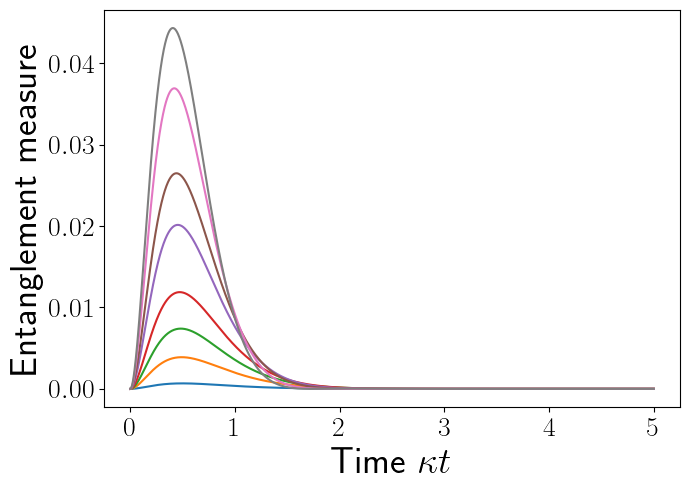

In [389]:
plt.figure(figsize=(7, 5))
t_min = []
for k, J in enumerate(Js):
    ind = np.argmax(od_mag[k])
    t_min.append(tlist[ind])
    if k in [0, 3, 5, 7, 10, 12, 15, 17, 20]:
        plt.plot(tlist, (od_mag[k]), label="$J = {}\kappa$".format(J))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time $\kappa t$", fontsize=27)
plt.ylabel("Entanglement measure", fontsize=27)
#plt.legend(edgecolor="k",fontsize=22)
plt.tight_layout()

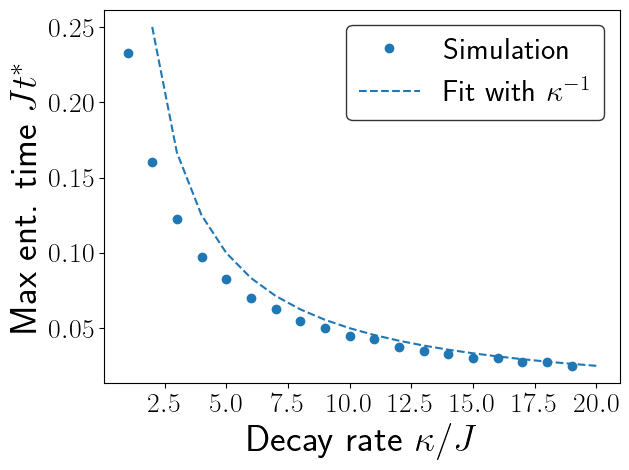

In [376]:
plt.plot(Js[1:], t_min[1:], 'o', label="Simulation")
plt.plot(kappas[1:], 0.5/ kappas[1:],  "--", color="tab:blue", label="Fit with $\kappa^{-1}$")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Decay rate $\kappa / J$", fontsize=27)
plt.ylabel("Max ent. time $Jt^*$", fontsize=27)
plt.legend(edgecolor="k",fontsize=22)
plt.tight_layout()
plt.savefig("entanglement_time_all_obs_ferm.pdf")

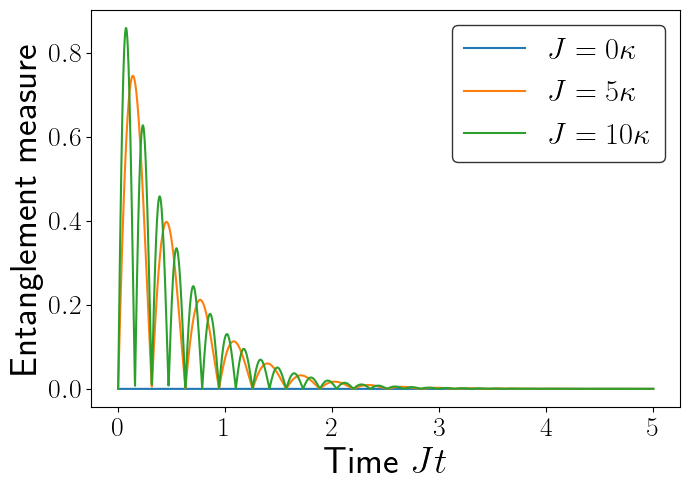

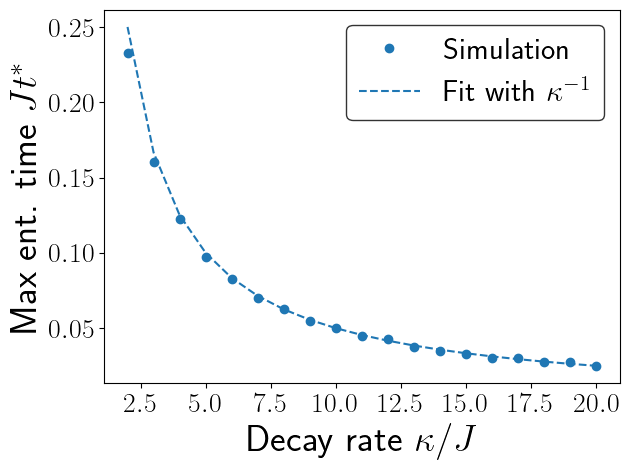

## Fermionic case: Even observables ##

In [3]:
a1 = qutip.tensor(qutip.qeye(2), qutip.qeye(2), qutip.qeye(2), qutip.destroy(2))
a2 = qutip.tensor(qutip.qeye(2), qutip.qeye(2), qutip.destroy(2), qutip.sigmaz())
a3 = qutip.tensor(qutip.qeye(2), qutip.destroy(2), qutip.sigmaz(), qutip.sigmaz())
a4 = qutip.tensor(qutip.destroy(2), qutip.sigmaz(), qutip.sigmaz(),  qutip.sigmaz())
H = a2 * a3 + a3.dag() * a2.dag()
vac = qutip.tensor(qutip.fock(2, 0), qutip.fock(2, 0), qutip.fock(2, 0), qutip.fock(2, 0))

# Construct projectors.
Q = np.zeros((4, 16), dtype=complex)
# 0 -> 00, 1 -> 01, 2 -> 10, 3 -> 11
Q[0, :] = (a3.dag() * vac).data.toarray()[:, 0]
Q[1, :] = (a4.dag() * vac).data.toarray()[:, 0]
Q[2, :] = (a2.dag() * a1.dag() * a3.dag() * vac).data.toarray()[:, 0]
Q[3, :] = (a2.dag() * a1.dag() * a4.dag() * vac).data.toarray()[:, 0]

In [220]:
kappas = np.linspace(0.1, 2.0, 20)
print(kappas)
tlist = np.linspace(0, 10, 2000)
psi_0 = (a1.dag() + a4.dag()) * vac / np.sqrt(2)
min_eigvals = []
for kappa in kappas:
    res = qutip.mesolve(H,psi_0,tlist,
                        [np.sqrt(kappa) * a1, np.sqrt(kappa) * a2, np.sqrt(kappa) * a3, np.sqrt(kappa) * a4,
                         np.sqrt(kappa) * a1.dag(), np.sqrt(kappa) * a2.dag(),
                         np.sqrt(kappa) * a3.dag(), np.sqrt(kappa) * a4.dag()])
    min_eigvals_kappa = []
    for k, t in enumerate(tlist):
        qs = Q @ res.states[k].data.toarray() @ Q.conj().T
        qs = qs / np.trace(qs)
        qs_ppt = np.array([[qs[0, 0], qs[1, 0], qs[0, 2], qs[1, 2]],
                           [qs[0, 1], qs[1, 1], qs[0, 3], qs[1, 3]],
                           [qs[2, 0], qs[3, 0], qs[2, 2], qs[3, 2]],
                           [qs[2, 1], qs[3, 1], qs[2, 3], qs[3, 3]]])
        eigvals, _ = np.linalg.eig(qs_ppt)
        min_eigvals_kappa.append(np.min(eigvals))
    min_eigvals.append(min_eigvals_kappa)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]


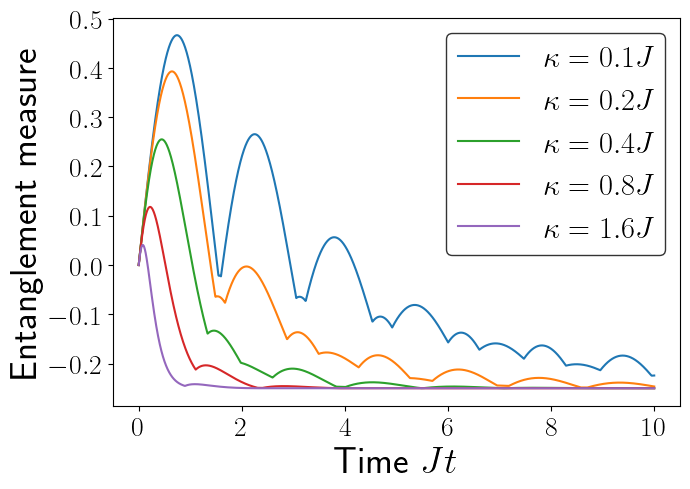

In [229]:
plt.figure(figsize=(7, 5))
t_min = []
for k, (kappa, min_eigvals_kappa) in enumerate(zip(kappas, min_eigvals)):
    ind = np.argmax(od_mag[k])
    t_min.append(tlist[ind])
    if k in [0, 1, 3, 7, 15]:
        plt.plot(tlist, -np.real(min_eigvals_kappa), label="$\kappa = {}J$".format((k + 1) * 0.1))

plt.legend(edgecolor="k", fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time $Jt$", fontsize=27)
plt.ylabel("Entanglement measure", fontsize=27)
plt.tight_layout()
plt.savefig("entanglement_even_obs_ferm.pdf")

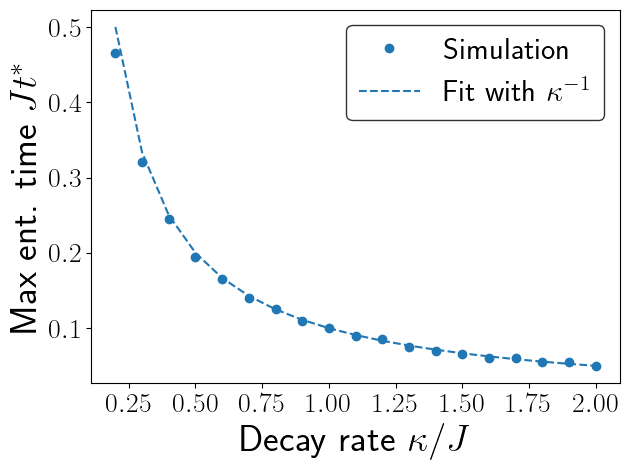

In [226]:
plt.plot(kappas[1:], t_min[1:], 'o', label="Simulation")
plt.plot(kappas[1:], 0.1/ kappas[1:],  "--", color="tab:blue", label="Fit with $\kappa^{-1}$")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Decay rate $\kappa / J$", fontsize=27)
plt.ylabel("Max ent. time $Jt^*$", fontsize=27)
plt.legend(edgecolor="k",fontsize=22)
plt.tight_layout()
plt.savefig("entanglement_time_even_obs_ferm.pdf")